# Analysis of the Combined data for 7pad Scanning

In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch, Circle

import numpy as np
from scipy.optimize import minimize

from single_pad_analysis.analysis_functions import *
from single_pad_analysis.HexDetector import HexDetector, hex_radius_inner_to_outer
from single_pad_analysis.SquareDetector import SquareDetector

In [2]:
run_number = 358
basedir_path = 'scan_pad_dfs/'
raw_file_dir = '/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/'
get_pad_csv_path = lambda pool_num, mm_channel: f'{basedir_path}Run{run_number}-Pool{pool_num}-{mm_channel}.csv'

pad_centers_df = pd.read_csv(f'{basedir_path}scan_pad_centers.csv')

In [3]:
print(pad_centers_df)

    run_number  pool_number channel_number   x_center  x_center_err  \
0          358            8             C2  39.494500      0.125742   
1          358            8             C4  29.462413      0.069197   
2          358            3             C2  48.561967      0.205440   
3          212            2             C2  34.220239      0.119373   
4          249            3             C2  43.872754      0.071042   
5          252            2             C2  14.206024      0.126835   
6          266            3             C2  54.012733      0.140700   
7          268            3             C4  14.366147      0.130118   
8          287            3             C4  44.310976      0.104306   
9          302            2             C4  44.212126      0.056453   
10         303            3             C2  33.899369      0.051008   
11         304            3             C4  33.790118      0.091257   
12         334            8             C4  36.631331      0.167951   
13    

In [4]:
pad_centers_df_filter = pad_centers_df[(pad_centers_df['run_number'] != 358) & (pad_centers_df['run_number'] != 383)]
df_scan = pad_centers_df[pad_centers_df['run_number'] == 358]

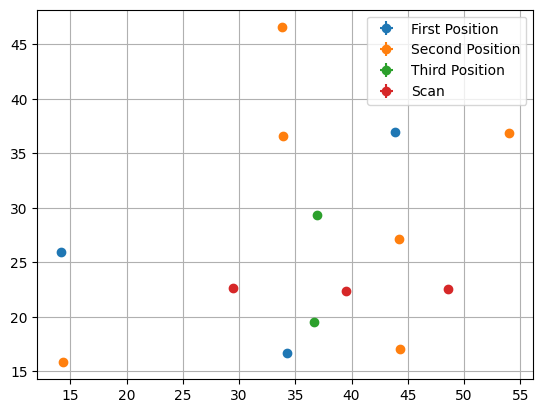

In [5]:
df_first_pos = pad_centers_df_filter[pad_centers_df_filter['run_number'] <= 252]
df_second_pos = pad_centers_df_filter[(pad_centers_df_filter['run_number'] > 252) & (pad_centers_df_filter['run_number'] < 334)]
df_third_pos = pad_centers_df_filter[(pad_centers_df_filter['run_number'] == 334) | (pad_centers_df_filter['run_number'] == 343)]
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='First Position')
ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Third Position')
ax.errorbar(df_scan['x_center'], df_scan['y_center'], xerr=df_scan['x_center_err'], yerr=df_scan['y_center_err'], fmt='o', zorder=10, label='Scan')
ax.grid(zorder=0)
ax.legend()

In [6]:
class Pad:
    def __init__(self, run_num, pool_num, mm_channel, pad_index=0):
        self.run_number = run_num
        self.pool_num = pool_num
        self.mm_channel = mm_channel
        self.pad_index = pad_index
        self.x_center = None
        self.y_center = None
        self.df = None

    def __repr__(self):
        return f"Pad(pool_num={self.pool_num}, mm_channel={self.mm_channel}, pad_index={self.pad_index}, x_center={self.x_center}, y_center={self.y_center})\n{self.df}"

In [7]:
pad_runs_2 = [
    266,
    268,
    287,
    302,
    303,
    304
]

pads_2 = []
for pad_i, run_number in enumerate(pad_runs_2):
    df_row = df_second_pos[df_second_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_2.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector2 = SquareDetector(5.0, 54.01, 36.88, np.deg2rad(0.0))
# detector.add_pad(0, -2, -1)
detector2.add_pad(0, -4, -2)
detector2.add_pad(0, -1, -2)
detector2.add_pad(0, -1, -1)
detector2.add_pad(0, -2, 0)
detector2.add_pad(0, -2, +1)

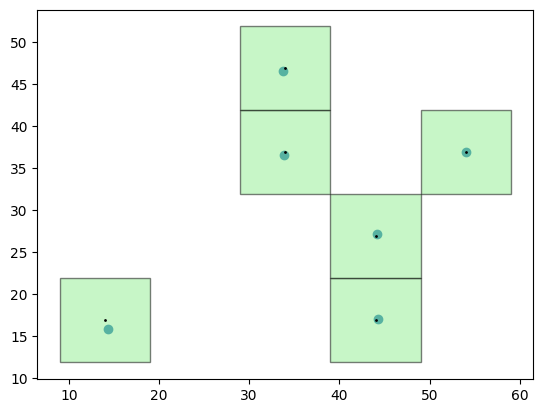

In [8]:
fig, ax = plt.subplots()
ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
# ax.grid(zorder=0)
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [9]:
# Align hex detector to pad centers
def chi_square(params, pads, detector):
    x_center, y_center, angle = params
    detector.set_rotation(np.deg2rad(angle))
    detector.set_center(x_center, y_center)

    chi2_dx, chi2_dy = 0, 0
    for pad in pads:
        det_x, det_y = detector.get_pad_center(pad.pad_index)
        chi2_dx += ((pad.x_center.val - det_x) / pad.x_center.err)**2
        chi2_dy += ((pad.y_center.val - det_y) / pad.y_center.err)**2

    return np.sum(chi2_dx + chi2_dy)


def fit_hex_detector_to_pad_centers(pads, detector, x0=0, y0=0, angle0=0):
    initial_guess = [x0, y0, angle0]
    bounds = ((0, 100), (0, 100), (-20, 20))  # No bounds on x and y, angle between -180 and 180 degrees
    result = minimize(chi_square, initial_guess, args=(pads, detector), bounds=bounds)
    return result

# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_2, detector2, x0=54.01, y0=36.88, angle0=5.5)
print(fit_result)
print(fit_result.x)
detector2.set_center(fit_result.x[0], fit_result.x[1])
detector2.set_rotation(np.deg2rad(fit_result.x[2]))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 29.39544468624986
        x: [ 5.389e+01  3.731e+01  1.857e+00]
      nit: 10
      jac: [-1.883e-05 -1.030e-05  4.832e-05]
     nfev: 48
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[53.8864827  37.31457955  1.85699321]


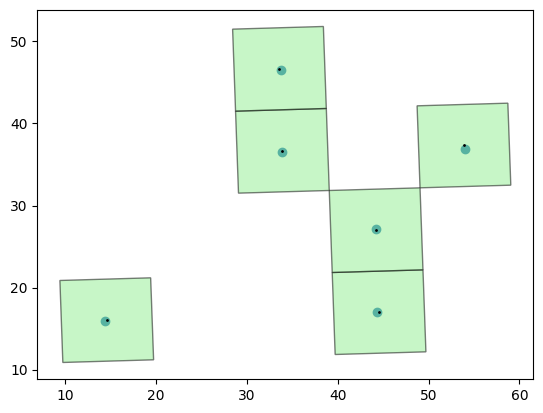

In [10]:
fig, ax = plt.subplots()
ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [11]:
pad_runs_1 = [
    212,
    249,
    252
]

pads_1 = []
for pad_i, run_number in enumerate(pad_runs_1):
    df_row = df_first_pos[df_first_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_1.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector1 = SquareDetector(5.0, 34.2, 16.66, np.deg2rad(0.0))
detector1.add_pad(0, +1, +2)
detector1.add_pad(0, -2, +1)

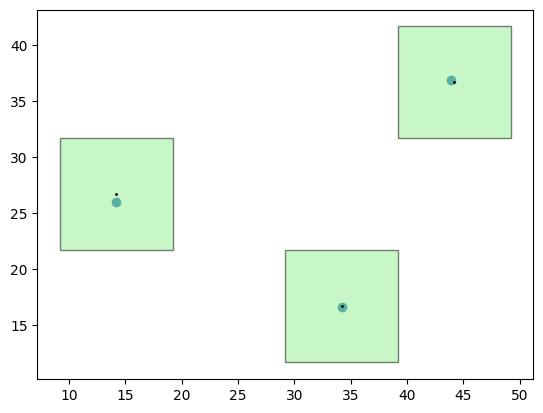

In [12]:
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.31784392663449
        x: [ 3.438e+01  1.664e+01  1.542e+00]
      nit: 9
      jac: [ 3.153e-06 -1.026e-05 -3.242e-06]
     nfev: 44
     njev: 11
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[34.38331423 16.63531408  1.54193165]


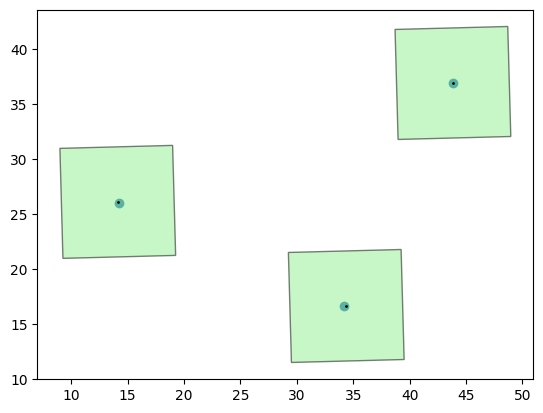

In [13]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_1, detector1, x0=34.2, y0=16.66, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector1.set_center(fit_result.x[0], fit_result.x[1])
detector1.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [14]:
pad_runs_3 = [
    334,
    343
]

pads_3 = []
for pad_i, run_number in enumerate(pad_runs_3):
    df_row = df_third_pos[df_third_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_3.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector3 = SquareDetector(5.0, 36.63, 19.56, np.deg2rad(0.0))
detector3.add_pad(0, 0, +1)

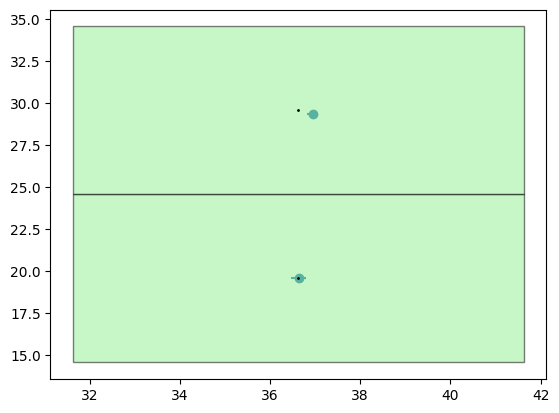

In [15]:
fig, ax = plt.subplots()
ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
# ax.grid(zorder=0)
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2.475033823322617
        x: [ 3.662e+01  1.952e+01 -1.906e+00]
      nit: 16
      jac: [-2.665e-07 -1.288e-06 -2.220e-07]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[36.61924618 19.52412232 -1.90552544]


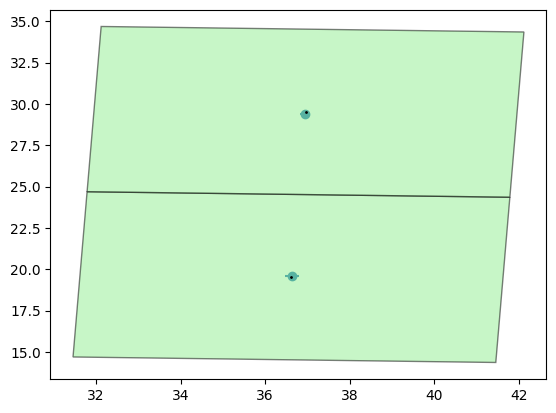

In [16]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_3, detector3, x0=36.63, y0=19.56, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector3.set_center(fit_result.x[0], fit_result.x[1])
detector3.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [17]:
pad_runs_4 = [
    358
]

df_scan_pool8 = df_scan[df_scan['pool_number'] == 8]
pad_channels_4 = [
    'C4',
    'C2'
]

pads_4 = []
for pad_i, channel_number in enumerate(pad_channels_4):
    df_row = df_scan_pool8[df_scan_pool8['channel_number'] == channel_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(358, int(pool_num), mm_channel, pad_i)
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{358}-Pool{pool_num}-{mm_channel}.csv')
    pads_4.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector4 = SquareDetector(5.0, 29.41, 22.67, np.deg2rad(0.0))
detector4.add_pad(0, +1, 0)

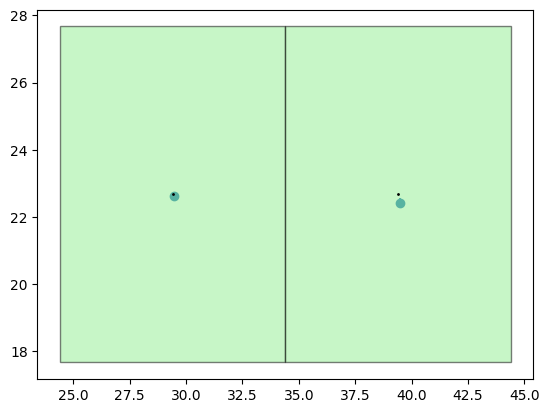

In [18]:
fig, ax = plt.subplots()
ax.errorbar(df_scan_pool8['x_center'], df_scan_pool8['y_center'], xerr=df_scan_pool8['x_center_err'], yerr=df_scan_pool8['y_center_err'], fmt='o', zorder=10, label='Scan')
# ax.grid(zorder=0)
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.055900621467041944
        x: [ 2.947e+01  2.262e+01 -1.099e+00]
      nit: 12
      jac: [-1.289e-05  1.736e-04  1.831e-06]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[29.47029908 22.6189831  -1.09876007]


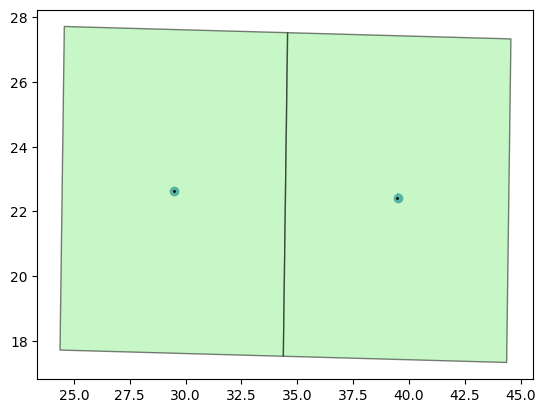

In [19]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_4, detector4, x0=29.41, y0=22.67, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector4.set_center(fit_result.x[0], fit_result.x[1])
detector4.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_scan_pool8['x_center'], df_scan_pool8['y_center'], xerr=df_scan_pool8['x_center_err'], yerr=df_scan_pool8['y_center_err'], fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20)

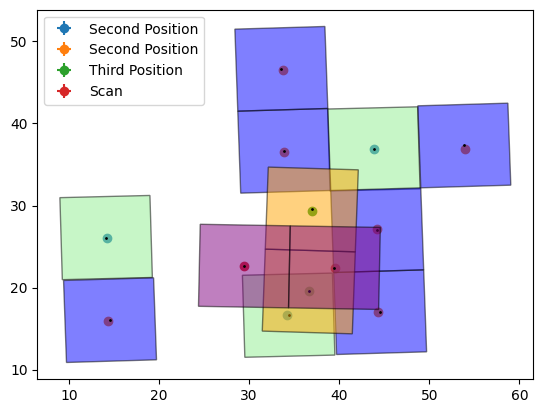

In [20]:
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)
ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='blue')
ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='orange')
ax.errorbar(df_scan_pool8['x_center'], df_scan_pool8['y_center'], xerr=df_scan_pool8['x_center_err'], yerr=df_scan_pool8['y_center_err'], fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='purple')
ax.legend()


In [21]:
det_1_rel_shift = np.array([-2, -2]) * 10
det_2_rel_shift = np.array([0, 0]) * 10
det_3_rel_shift = np.array([-3, -1]) * 10
det_4_rel_shift = np.array([-5, 0]) * 10

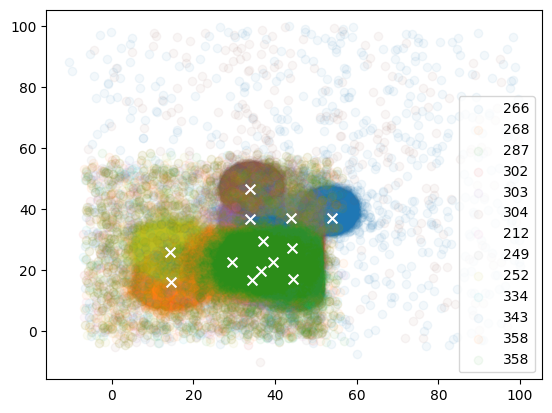

In [22]:
fig, ax = plt.subplots()
for pad_i in range(len(pads_2)):
    sc = ax.scatter(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], label=f'{pads_2[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_2[pad_i].x_center.val, pads_2[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_1)):
    sc = ax.scatter(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], label=f'{pads_1[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_1[pad_i].x_center.val, pads_1[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], label=f'{pads_3[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_3[pad_i].x_center.val, pads_3[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_4)):
    sc = ax.scatter(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], label=f'{pads_4[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_4[pad_i].x_center.val, pads_4[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
ax.legend()

In [23]:
# Rotate everything to square up detector
for pad_i in range(len(pads_1)):
    pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'] = rotate_points(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], -detector1.rotation, detector1.x, detector1.y) + det_1_rel_shift[:, np.newaxis]
    # df_first_pos['x_center'], df_first_pos['y_center'] = rotate_points(df_first_pos['x_center'], df_first_pos['y_center'], -detector1.rotation, detector1.x, detector1.y)
    pads_1[pad_i].x_center, pads_1[pad_i].y_center = rotate_points(pads_1[pad_i].x_center, pads_1[pad_i].y_center, -detector1.rotation, detector1.x, detector1.y) + det_1_rel_shift
detector1.set_center(*det_1_rel_shift)
detector1.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_2)):
    pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'] = rotate_points(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], -detector2.rotation, detector2.x, detector2.y) + det_2_rel_shift[:, np.newaxis]
    # df_second_pos['x_center'], df_second_pos['y_center'] = rotate_points(df_second_pos['x_center'], df_second_pos['y_center'], -detector2.rotation, detector2.x, detector2.y)
    pads_2[pad_i].x_center, pads_2[pad_i].y_center = rotate_points(pads_2[pad_i].x_center, pads_2[pad_i].y_center, -detector2.rotation, detector2.x, detector2.y) + det_2_rel_shift
detector2.set_center(*det_2_rel_shift)
detector2.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_3)):
    pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'] = rotate_points(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], -detector3.rotation, detector3.x, detector3.y) + det_3_rel_shift[:,np.newaxis]
    # df_third_pos['x_center'], df_third_pos['y_center'] = rotate_points(df_third_pos['x_center'], df_third_pos['y_center'], -detector3.rotation, detector3.x, detector3.y)
    pads_3[pad_i].x_center, pads_3[pad_i].y_center = rotate_points(pads_3[pad_i].x_center, pads_3[pad_i].y_center, -detector3.rotation, detector3.x, detector3.y) + det_3_rel_shift
detector3.set_center(*det_3_rel_shift)
detector3.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_4)):
    pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'] = rotate_points(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], -detector4.rotation, detector4.x, detector4.y) + det_4_rel_shift[:,np.newaxis]
    # df_third_pos['x_center'], df_third_pos['y_center'] = rotate_points(df_third_pos['x_center'], df_third_pos['y_center'], -detector3.rotation, detector3.x, detector3.y)
    pads_4[pad_i].x_center, pads_4[pad_i].y_center = rotate_points(pads_4[pad_i].x_center, pads_4[pad_i].y_center, -detector4.rotation, detector4.x, detector4.y) + det_4_rel_shift
detector4.set_center(*det_4_rel_shift)
detector4.set_rotation(np.deg2rad(0.))

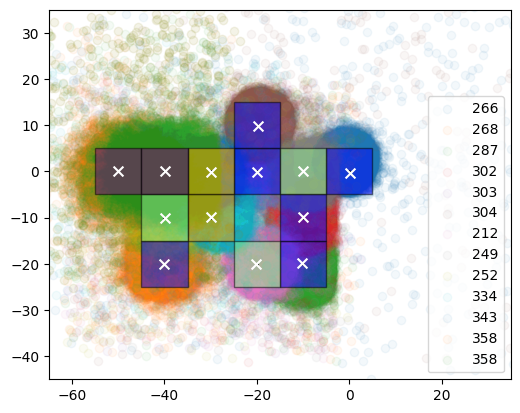

In [24]:
fig, ax = plt.subplots()
for pad_i in range(len(pads_2)):
    sc = ax.scatter(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], label=f'{pads_2[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_2[pad_i].x_center.val, pads_2[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='blue')

for pad_i in range(len(pads_1)):
    sc = ax.scatter(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], label=f'{pads_1[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_1[pad_i].x_center.val, pads_1[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=5)

for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], label=f'{pads_3[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_3[pad_i].x_center.val, pads_3[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='orange')

for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], label=f'{pads_4[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_4[pad_i].x_center.val, pads_4[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='purple')

ax.legend()
ax.set_ylim(-45, 35)
ax.set_xlim(-65, 35)
ax.set_aspect('equal')

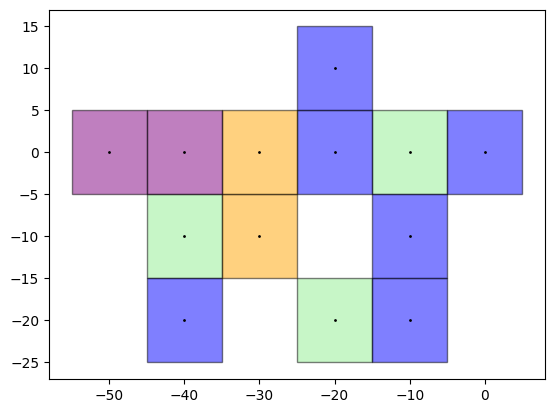

In [25]:
fig, ax = plt.subplots()
# ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)
# ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='blue')
# ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='orange')
# ax.errorbar(df_scan_pool8['x_center'], df_scan_pool8['y_center'], xerr=df_scan_pool8['x_center_err'], yerr=df_scan_pool8['y_center_err'], fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='purple')

In [26]:
threshold = 2

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.2)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
# ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.4, pad_colors='none')

NameError: name 'pads' is not defined

In [ ]:
df_combined['r_center'] = np.sqrt((df_combined['hitX'] - detector.x)**2 + (df_combined['hitY'] - detector.y)**2)
r_center_cut = 7.5  # mm, should correspond to centers of surrounding pads
df_filter = df_combined[df_combined['r_center'] < r_center_cut]
x_tracks, y_tracks = df_filter['hitX'], df_filter['hitY']

# Assume pads is a list of Pad objects
weights, x_weighted, y_weighted, n_hits = [], [], [], []

for pad in pads:
    pad_idx = pad.pad_index
    weight = df_filter[f'totcharge_{pad_idx}'].fillna(0)
    weights.append(weight)
    n_hits.append(df_filter[f'totcharge_{pad_idx}'].notna().astype(int))
    x_weighted.append(pad.x_center.val * weight)
    y_weighted.append(pad.y_center.val * weight)

weight_sum = sum(weights)
n_hits = sum(n_hits)
x_hits = sum(x_weighted) / weight_sum
y_hits = sum(y_weighted) / weight_sum

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x_hits, y_hits, cmap='viridis', s=5, zorder=2, alpha=0.5)
circle = Circle((pads[0].x_center.val, pads[0].y_center.val), r_center_cut, color='orange', fill=False, zorder=3, label='r cut')
ax.add_patch(circle)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
# ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)
ax.legend()

# Plot n_hits histogram
fig_nhits, ax_nhits = plt.subplots(figsize=(8, 6))
ax_nhits.hist(n_hits, bins=np.arange(0 - 0.5, np.max(n_hits) + 2 - 0.5, 1))
ax_nhits.set_xlabel('Number of Pads Hit')
ax_nhits.set_ylabel('Events')

# Get residuals
x_resids = np.array(x_hits) - np.array(x_tracks)
y_resids = np.array(y_hits) - np.array(y_tracks)

binning = np.linspace(-10, 10, 100)
bin_centers = (binning[1:] + binning[:-1]) / 2

x_resid_hist, x_resid_bin_edges = np.histogram(x_resids, bins=binning)
x_resid_err = np.where(x_resid_hist > 0, np.sqrt(x_resid_hist), 1)
y_resid_hist, y_resid_bin_edges = np.histogram(y_resids, bins=binning)
y_resid_err = np.where(y_resid_hist > 0, np.sqrt(y_resid_hist), 1)

x_resid_popt, x_resid_pcov = cf(gaus, bin_centers, x_resid_hist, p0=[np.max(x_resid_hist), np.mean(x_resids), np.std(x_resids)], sigma=x_resid_err, absolute_sigma=True)
x_resid_meases = [Measure(val, err) for val, err in zip(x_resid_popt, np.sqrt(np.diag(x_resid_pcov)))]
y_resid_popt, y_resid_pcov = cf(gaus, bin_centers, y_resid_hist, p0=[np.max(y_resid_hist), np.mean(y_resids), np.std(y_resids)], sigma=y_resid_err, absolute_sigma=True)
y_resid_meases = [Measure(val, err) for val, err in zip(y_resid_popt, np.sqrt(np.diag(y_resid_pcov)))]

x_plt = np.linspace(binning[0], binning[-1], 200)

fig_resids, ax_resids = plt.subplots(ncols=2, figsize=(12, 6), sharey='all', sharex='all')
ax_resids[0].errorbar(bin_centers, x_resid_hist, yerr=x_resid_err, color='black', fmt='o', ls='none')
ax_resids[1].errorbar(bin_centers, y_resid_hist, yerr=y_resid_err, color='black', fmt='o', ls='none')
ax_resids[0].plot(x_plt, gaus(x_plt, *x_resid_popt), color='red')
ax_resids[1].plot(x_plt, gaus(x_plt, *y_resid_popt), color='red')
ax_resids[0].axhline(0, color='black', alpha=0.5)
ax_resids[1].axhline(0, color='black', alpha=0.5)
ax_resids[0].set_xlabel('x residual [mm]')
ax_resids[1].set_xlabel('y residual [mm]')
x_fit_str = f'A={x_resid_meases[0]}\nμ={x_resid_meases[1]} mm\nσ={x_resid_meases[2]} mm'
ax_resids[0].annotate(x_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
y_fit_str = f'A={y_resid_meases[0]}\nμ={y_resid_meases[1]} mm\nσ={y_resid_meases[2]} mm'
ax_resids[1].annotate(y_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
fig_resids.subplots_adjust(wspace=0)

fig_resids_nhits, ax_resids_nhits = plt.subplots(ncols=2, figsize=(10, 6))
n_hits_plt, res_x_plt, res_y_plt = [], [], []
for n_hit_i in range(1, max(n_hits) + 1):
    x_hist_i, _, _ = ax_resids_nhits[0].hist(x_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    y_hist_i, _, _ = ax_resids_nhits[1].hist(y_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    popt_x, pcov_x = cf(gaus, bin_centers, x_hist_i, p0=[np.max(x_hist_i), np.mean(x_resids[n_hits == n_hit_i]), np.std(x_resids[n_hits == n_hit_i])])
    pmeas_x = [Measure(val, err) for val, err in zip(popt_x, np.sqrt(np.diag(pcov_x)))]
    popt_y, pcov_y = cf(gaus, bin_centers, y_hist_i, p0=[np.max(y_hist_i), np.mean(y_resids[n_hits == n_hit_i]), np.std(y_resids[n_hits == n_hit_i])])
    pmeas_y = [Measure(val, err) for val, err in zip(popt_y, np.sqrt(np.diag(pcov_y)))]
    n_hits_plt.append(n_hit_i)
    res_x_plt.append(abs(pmeas_x[2]))
    res_y_plt.append(abs(pmeas_y[2]))

ax_resids_nhits[0].legend()
ax_resids_nhits[0].set_xlabel('x residual [mm]')
ax_resids_nhits[1].set_xlabel('y residual [mm]')

fig_resolutions, ax_resolutions = plt.subplots(figsize=(10, 6))
ax_resolutions.errorbar(n_hits_plt, [x.val for x in res_x_plt], yerr=[x.err for x in res_x_plt], label='X Resolution', ls='none', marker='o')
ax_resolutions.errorbar(n_hits_plt, [y.val for y in res_y_plt], yerr=[y.err for y in res_y_plt], label='Y Resolution', ls='none', marker='o')
ax_resolutions.legend()
ax_resolutions.set_ylabel('Resolution [mm]')
ax_resolutions.set_xlabel('Number of Pads Hit')
ax_resolutions.grid(zorder=0)

In [ ]:
weights, charge_weights, charges, time_diffs_weighted, time_diff_cors_weighted, time_diff_cors_charge_weighted, time_diffs_max, time_diff_cors_max = [], [], [], [], [], [], [], []
for pad in pads:
    pad_idx = pad.pad_index
    weight = (df_combined[f'charge_time_res_{pad_idx}'] ** -2).fillna(0)
    charge_weight = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, weight, 0)
    charge_weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, charge_weight, 0)

    charges = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    time_diff = df_combined[f'time_diff_{pad_idx}'].fillna(0)
    time_diff_cor = df_combined[f'time_diff_cor_{pad_idx}'].fillna(0)
    weights.append(weight)
    charge_weights.append(charge_weight)
    time_diffs_weighted.append(time_diff * weight)
    time_diff_cors_weighted.append(time_diff_cor * weight)
    time_diff_cors_charge_weighted.append(time_diff_cor * charge_weight)
    time_diffs_max.append(time_diff)
    time_diff_cors_max.append(time_diff_cor)

# Calculate the weighted average of time_diff and time_diff_cor
weight_sum = sum(weights)
charge_weight_sum = sum(charge_weights)
time_diff_weighted = sum(time_diffs_weighted) / weight_sum
time_diff_cor_weighted = sum(time_diff_cors_weighted) / weight_sum
time_diff_cor_charge_weighted = sum(time_diff_cors_charge_weighted) / charge_weight_sum

# Build arrays for charges and time_diff_cors
charge_array = np.stack([
    df_combined[f'totcharge_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

time_diff_array = np.stack([
    df_combined[f'time_diff_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)

time_diff_cor_array = np.stack([
    df_combined[f'time_diff_cor_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

# For each row (event), get the index of the pad with max charge
max_charge_indices = np.argmax(charge_array, axis=1)  # shape: (n_events,)

# Use advanced indexing to select the time_diff_cor at that index
time_diffs_max = time_diff_array[np.arange(charge_array.shape[0]), max_charge_indices]
time_diff_cors_max = time_diff_cor_array[np.arange(charge_array.shape[0]), max_charge_indices]

time_diff_cor_weighted = np.where((time_diff_cor_weighted < -1) | (time_diff_cor_weighted > 1), np.nan, time_diff_cor_weighted)
time_diff_cor_charge_weighted = np.where((time_diff_cor_charge_weighted < -1) | (time_diff_cor_charge_weighted > 1), np.nan, time_diff_cor_charge_weighted)

# Plot 2D scatter plot of histX_0 and histY_0 with color determined by sats_cor
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=time_diff_cor_weighted, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Average')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, 4), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, -4), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (-4, 2.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (4, 2.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (-5, -4.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (5, -4.5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (0, 5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
# center_point, radius = (-6, 5), 1.5  # mm
center_point, radius = (6, 5), 1.5  # mm
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
# get_circle_scan(time_diff_cor_charge_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98))
get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], [center_point], ns_to_ps=True, radius=radius, plot=True, percentile_cuts=(2, 98), nsigma_filter=3)

In [ ]:
scan_radius = 1.5
min_events_per_circle = 250

n_steps_2D = 150
scan_xs = np.linspace(detector.x - 15, detector.x + 15, n_steps_2D + 1)
scan_ys = np.linspace(detector.y - 15, detector.y + 15, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor_weighted, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), nsigma_filter=3, plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius, percentile_filter=[0, 95])

In [ ]:
n_steps = 50
full_scan_radius = 15
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='all', sharex='all')
axs = axs.flatten()
angles = [0, 30, 45, 60, 90, 120, 135, 150]  # degrees
for idx, angle in enumerate(angles):
    ax = axs[idx]
    xy_pairs = generate_line_scan(detector.x, detector.y, full_scan_radius, n_steps, angle)

    # Plot detector with scan line in plot
    inset_ax = inset_axes(ax, width=2, height=2, loc='upper center')
    inset_ax.set_axis_off()
    detector.plot_detector(global_coords=True, ax_in=inset_ax, pad_alpha=0.8)
    # inset_ax.plot([xy[0] for xy in xy_pairs], [xy[1] for xy in xy_pairs], color='red', lw=2)
    inset_ax.scatter([xy[0] for xy in xy_pairs], [xy[1] for xy in xy_pairs], color='red', alpha=0.1, s=130, zorder=11)
    # inset_ax.fill_between([xy[0] for xy in xy_pairs], np.array([xy[1] for xy in xy_pairs]) - scan_radius, np.array([xy[1] for xy in xy_pairs]) + scan_radius, color='red', alpha=0.5)
    arrow = FancyArrowPatch(
        posA=xy_pairs[0],
        posB=xy_pairs[-1],
        arrowstyle='->',          # or '-|>', 'fancy', etc.
        color='red',
        linewidth=2,
        zorder=12,
        mutation_scale=20         # controls arrowhead size
    )

    inset_ax.add_patch(arrow)
    inset_ax.set_aspect('equal')

    for time_diff_cors_i, cor_name in zip([time_diff_cors_max, time_diff_cor_charge_weighted, time_diff_cor_weighted], ['Max Pad', 'Charge Weighted', 'Resolution Weighted']):

        scan_resolutions, scan_means, events = get_circle_scan(
            time_diff_cors_i, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs,
            radius=scan_radius,
            min_events=min_events_per_circle,
            ns_to_ps=True,
            percentile_cuts=(2, 98),
            plot=False
        )

        # Relative position along the line, in mm
        ts = np.linspace(-scan_radius, scan_radius, len(scan_resolutions))  # line distances
        means = np.array([m.val for m in scan_resolutions])
        errors = np.array([m.err for m in scan_resolutions])

        # ax.errorbar(ts, means, yerr=errors, fmt='o', label=f"{cor_name} {angle}°", alpha=0.8)
        ax.plot(ts, means, alpha=0.5)
        ax.fill_between(ts, means + errors, means - errors, alpha=0.5, label=f'{cor_name}')
        ax.annotate(
            f'{angle}°',
            xy=(0.3, 0.9),  # x, y in axes fraction (0=left/bottom, 1=right/top)
            xycoords='axes fraction', ha='center', va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"),
            fontsize=18,
            color='black'
        )

    if idx % 2 == 0:
        ax.set_ylabel("Time Resolution (ps)")
    ax.grid(True)
    if idx == 1:
        ax.legend()


axs[-1].set_xlabel("Relative Position along scan line (cm)")
axs[-2].set_xlabel("Relative Position along scan line (cm)")

axs[0].set_ylim(bottom=31, top=59)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
fig, ax = plt.subplots()
ax.hist(df_combined[f'time_diff_0'], bins=np.linspace(-15, -5, 1000))

In [ ]:
time_walk_nbins = 50  # For SAT vs charge
n_charge_bins = 50  # For resolution vs charge fits
abs_t_max = 15  # Quick and sloppy way to remove outliers

time_walk_func = time_walk_double_exponential
p0_time_walk = [1.0, -0.1, 0.5, -0.1, 4] #ampl1, decay1, amp2, decay2, bsl

p0_resol = [30, -0.1, 10, -0.05, 20]
resol_func = time_walk_double_exponential
resolution_correction_to_use = 'Corrected Gaus'  # Correction to use moving forward

binning_type = 'equal_stats'
percentile_cut=(2, 98)
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
for pad in pads:
    pad_idx = pad.pad_index
    rs = np.sqrt((df_combined[f'hitX'] - pad.x_center.val)**2 + (df_combined[f'hitY'] - pad.y_center.val)**2)
    df_pad = df_combined[(rs < r_outer) & (np.abs(df_combined[f'time_diff_{pad_idx}']) < abs_t_max)]

    time_diffs_i, charges_i = df_pad[f'time_diff_{pad_idx}'], df_pad[f'totcharge_{pad_idx}']
    charges_i, time_diffs_i = filter_sort_charges_time_diffs(time_diffs_i, charges_i)
    fig3, ax3 = plt.subplots()
    ax3.scatter(charges_i, time_diffs_i)
    ax3.set_xlabel('Total Charge[pC]')
    ax3.set_ylabel('SAT [ps]')
    avg_charges, med_time_diffs, std_err_time_diffs, gaus_means, gaus_mean_errs = get_time_walk_binned(time_diffs_i, charges_i, binning_type, time_walk_nbins, percentile_cut)
    ax.errorbar(avg_charges, gaus_means, yerr=gaus_mean_errs, fmt='.', label=f'Pad {pad_idx}')
    ax.set_xlabel('Total Charge[pC]')
    ax.set_ylabel('SAT [ps]')
    ax2.errorbar(avg_charges, np.array(gaus_means) - np.mean(gaus_means), yerr=gaus_mean_errs, fmt='.', alpha=0.5, label=f'Pad {pad_idx}')
    ax2.set_xlabel('Total Charge[pC]')
    ax2.set_ylabel('SAT [ps]')
    if np.max(gaus_mean_errs) > 1000:
        print(f'Pad {pad_idx} is too big -- {np.max(gaus_mean_errs)}')
ax2.legend()
ax2.set_ylim(bottom=-0.05, top=0.1)


In [ ]:
scan_radius = 1.5
min_events_per_circle = 20

n_steps_2D = 150
scan_xs = np.linspace(detector.x - 15, detector.x + 15, n_steps_2D + 1)
scan_ys = np.linspace(detector.y - 15, detector.y + 15, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

hits = ~pd.isna(time_diff_cor_weighted)
efficiencies, eff_events = get_circle_efficiency_scan(hits, df_combined[f'hitX'], df_combined[f'hitY'], xy_pairs, radius=scan_radius, min_events=min_events_per_circle)
plot_2D_efficiency_scan(efficiencies, scan_xs, scan_ys, scan_events=eff_events, radius=scan_radius)